In [1]:
import numpy as np
import pandas as pd

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [192]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# 주가 URL
samsung_url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/B05_KM_StockPrice_for_regression.xlsx'
lg_url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/B05_KM_StockPrice_066570_LG%EC%A0%84%EC%9E%90_200601-210416.xlsx'
yg_url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/B05_KM_StockPrice_122870_YG_200101-210416.xlsx'
jyp_url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/B05_KM_StockPrice_035900_JYP_200101-210416.xlsx'

In [3]:
# 주가 데이터 불러오기
samsung_stock = pd.read_excel(samsung_url, header=0)
lg_stock = pd.read_excel(lg_url, header=0)
yg_stock = pd.read_excel(yg_url, header=0)
jyp_stock = pd.read_excel(jyp_url, header=0)

# 삼성

In [4]:
samsung_stock[:3]

,Date,Open,High,Low,Close,Volume,Change
0,1997-05-03,1090,1093,1077,1087,67197,NaN
1,1997-05-06,1086,1093,1081,1092,93290,0.00460
2,1997-05-07,1084,1088,1077,1085,67110,-0.00641


## 정규화

In [186]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
samsung_scaled = scaler.fit_transform(samsung_stock[scale_cols])
samsung_scaled = pd.DataFrame(samsung_scaled)
samsung_scaled.columns = scale_cols
samsung_scaled['Date'] = samsung_stock['Date']

In [187]:
# 역 minmax 스케일링
# 정규화된 종가 데이터 -> 원래 종가
def reverse_min_max_scaling(org_x, x): 
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [190]:
def make_dataset(data, label, window_size=20):  #> 데이터 셋 window_size 수 만큼의 일주가 데이터로 예측 하기위해 dataset 나눔.
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))   # 예측하고자 하는 날의 전날부터 20일전까지의 주가 데이터
        label_list.append(np.array(label.iloc[i+window_size]))      # 예측하고자 하는 날의 label(Close:종가) 데이터
    return np.array(feature_list), np.array(label_list)

## LSTM

In [222]:
# 삼성 주가 기사
filepath = '/content/samsung_only_all.xlsx'
sentiment_data = pd.read_excel(filepath, usecols=['Data', 's'])

In [145]:
# 주가 기사 date 컬럼 데이터타입 datetime 형식으로 바꾸기
sentiment_data['Data'] = [ data.split(' ')[0] for data in sentiment_data['Data']] 
sentiment_data['Data'] = [ datetime.datetime.strptime(data, '%Y.%m.%d') for data in sentiment_data['Data']]

In [208]:
news_count = {} # 해당 날짜의 뉴스 기사 개수 카운트. 날짜를 key로 가지는 dict
sen_result = {} # 해당 날짜의 감성분석 값의 합계. 날짜를 key로 가지는 dict
for i in range(len(sentiment_data)):
    
    data = sentiment_data.iloc[i]  

    if data['Data'] in list(news_count.keys()): 
        news_count[data['Data']] += 1           
    else:
        news_count[data['Data']] = 0

    if data['Data'] in list(sen_result.keys()):
        sen_result[data['Data']] += data['s']
    else:
        sen_result[data['Data']] = 0

In [209]:
news_count = pd.DataFrame(list(news_count.items()), columns=['Date', 'news_count']).sort_values(['Date'])

In [210]:
sen_result = pd.DataFrame(list(sen_result.items()), columns=['Date', 'sen_result']).sort_values(['Date'])

In [211]:
# 뉴스기사 개수, 감성의 합계를 가지는 데이터프레임 합치기
data = pd.merge(news_count, sen_result, left_on='Date', right_on='Date')

In [212]:
data

,Date,news_count,sen_result
0,2020-12-21,0,0
1,2020-12-22,17,11
2,2020-12-23,7,5
3,2020-12-24,10,8
4,2020-12-25,0,0
...,...,...,...
108,2021-04-10,3,2
109,2021-04-11,4,-2
110,2021-04-12,18,11
111,2021-04-13,21,1


In [213]:
# 해당 날짜의 감성 평균값 구해서 result 컬럼의 값으로 넣기
data['result'] = data['sen_result'] / data['news_count']

In [214]:
# 스케일링된 데이터에 합치기, nan값(기사가 없는 날짜)은 0 으로 대체
samsung_scaled = samsung_scaled.merge(data, left_on='Date', right_on='Date', how='left').replace(np.nan, 0)

In [215]:
samsung_scaled

,Open,High,Low,Close,Volume,Date,news_count,sen_result,result
0,0.012071,0.011291,0.012034,0.005090,0.000744,1997-05-03,0.0,0.0,0.0
1,0.012027,0.011291,0.012078,0.005145,0.001033,1997-05-06,0.0,0.0,0.0
2,0.012004,0.011240,0.012034,0.005068,0.000743,1997-05-07,0.0,0.0,0.0
3,0.011993,0.011188,0.011777,0.004736,0.000804,1997-05-08,0.0,0.0,0.0
4,0.011717,0.011023,0.011721,0.004847,0.000892,1997-05-09,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5994,0.918051,0.857438,0.920670,0.904839,0.154306,2021-04-22,0.0,0.0,0.0
5995,0.906977,0.856405,0.911732,0.909265,0.197163,2021-04-23,0.0,0.0,0.0
5996,0.918051,0.862603,0.922905,0.917011,0.171527,2021-04-26,0.0,0.0,0.0
5997,0.921373,0.860537,0.921788,0.910371,0.143307,2021-04-27,0.0,0.0,0.0


In [216]:
TEST_SIZE = 200    # 최근 200일간의 주가를 예측하겠다
WINDOW_SIZE = 20   # 20일의 데이터를 기반으로 다음날 주가를 예측하겠다

train = samsung_scaled[:-TEST_SIZE]     
test = samsung_scaled[-TEST_SIZE:]      # 최근 200일간의 데이터 -> test 데이터

In [217]:
#feature_cols = ['Open']
feature_cols = ['Open', 'High', 'Low', 'Volume', 'result']    # 특성 값 5개
label_cols = ['Close']  # label 데이터(종가)

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset 생성
train_feature, train_label = make_dataset(train_feature, train_label, window_size=20)

# train, validation set 생성
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

print(x_train.shape, x_valid.shape)

# test dataset (실제 예측 해볼 데이터)
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
print(test_feature.shape, test_label.shape)

(4623, 20, 5) (1156, 20, 5)
(180, 20, 5) (180, 1)


In [223]:
model = Sequential()
model.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('temp.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, epochs=200, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
289/289 [==============================] - 4s 10ms/step - loss: 0.0037 - val_loss: 1.5693e-04

Epoch 00001: val_loss improved from inf to 0.00016, saving model to temp.h5
Epoch 2/200
289/289 [==============================] - 3s 9ms/step - loss: 1.1435e-04 - val_loss: 1.3463e-04

Epoch 00002: val_loss improved from 0.00016 to 0.00013, saving model to temp.h5
Epoch 3/200
289/289 [==============================] - 3s 9ms/step - loss: 9.4966e-05 - val_loss: 9.9503e-05

Epoch 00003: val_loss improved from 0.00013 to 0.00010, saving model to temp.h5
Epoch 4/200
289/289 [==============================] - 3s 9ms/step - loss: 9.5225e-05 - val_loss: 1.1027e-04

Epoch 00004: val_loss did not improve from 0.00010
Epoch 5/200
289/289 [==============================] - 3s 9ms/step - loss: 7.9906e-05 - val_loss: 9.0736e-05

Epoch 00005: val_loss improved from 0.00010 to 0.00009, saving model to temp.h5
Epoch 6/200
289/289 [==============================] - 3s 9ms/step - loss: 8.6963e-05 

In [224]:
# 모델로 예측한 180일간의 주가 
predicted_stock = model.predict(test_feature)

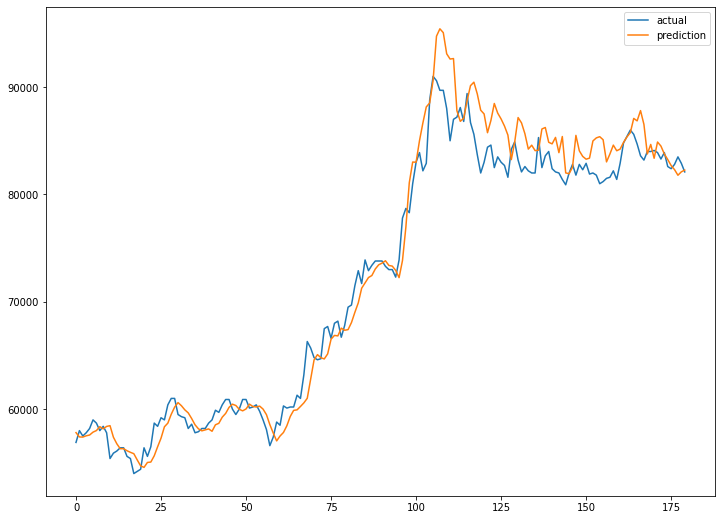

In [225]:
plt.figure(figsize=(12, 9))
plt.plot(reverse_min_max_scaling(samsung_stock['Close'], test_label), label = 'actual')
plt.plot(reverse_min_max_scaling(samsung_stock['Close'], predicted_stock), label = 'prediction')
plt.legend()
plt.show()

In [226]:
model.evaluate(test_feature, test_label)    #> mse 값 0.00064498

6/6 [==============================] - 0s 4ms/step - loss: 6.4499e-04


0.0006449869251810014